### <a id='lib'></a> Libraries and variables

In [2]:
print('This notebook was prepared using:')

import os
import sys
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import math
from math import isnan

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

import re
import sys
import argparse
import scipy as sp
try:
    import itertools.izip as zip
except ImportError:
    import itertools
import random

from scipy import integrate
import scipy.interpolate as sp_interpolate
import statistics

from dataclasses import dataclass
import time as time_module
import importlib
import subprocess

import epitope

# GitHub
HIV_DIR = 'data/HIV'
SIM_DIR = 'data/simulation'
FIG_DIR = 'figures'
MPL_DIR = 'src'

NUC = ['-', 'A', 'C', 'G', 'T']

ppts = ['700010040', '700010058', '700010077', '700010470', '700010607', '703010131', '703010159', 
       '703010256', '704010042', '705010162', '705010185', '705010198', '706010164']

tags = ['700010040-3', '700010040-5', '700010058-3', '700010058-5', '700010077-3', '700010077-5',
        '700010470-3', '700010470-5', '700010607-3', '700010607-5', '703010131-3', '703010131-5', 
        '703010159-3', '703010159-5', '703010256-3', '703010256-5', '704010042-3', '704010042-5', 
        '705010162-3', '705010162-5', '705010185-3', '705010185-5', '705010198-3', '705010198-5', 
        '706010164-3', '706010164-5']  

This notebook was prepared using:
python version 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
numpy version 1.26.4
pandas version 1.5.3
matplotlib version 3.7.1


In [3]:
'''Find fixation frequency'''
fix_tags = ['700010040-3','700010040-5','704010042-3','704010042-5','700010058-5',
            '700010077-3','703010131-3','703010159-3','705010162-3','706010164-3','703010256-3',
            '700010470-3','700010470-5','700010607-3']

for tag in fix_tags:
    
    data_pro     = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle="True")
    escape_group = data_pro['escape_group']
    x            = data_pro['single_freq']
    sample_times = data_pro['sample_times']
    ne           = len(escape_group)
                
    fixation_time = np.zeros(ne)
    for n in range(ne):
        x_epitope = x.T[-ne+n]

        # check if the mutant epitope is fixed
        if np.max(x_epitope[:-1]) == 1 and x_epitope[-1] == 1:
            # Find the fixation time
            for ti in range(len(x_epitope)-1):
                if x_epitope[ti] == 1 and x_epitope[ti+1] == 1:
                    fixation_time[n] = sample_times[ti]
                    break
                    
    print(f'{tag} - {int(sample_times[-1])} - {fixation_time} ')

700010040-3 - 552 - [  0.   0. 111.] 
700010040-5 - 552 - [45.] 
704010042-3 - 676 - [60.  0.  0.] 
704010042-5 - 676 - [60.] 
700010058-5 - 350 - [154.] 
700010077-3 - 159 - [  0.   0.  32. 102.   0.  32.] 
703010131-3 - 333 - [34.] 
703010159-3 - 302 - [85. 56.] 
705010162-3 - 438 - [  0. 179.   0.] 
706010164-3 - 434 - [183.] 
703010256-3 - 684 - [  0.   0. 172.] 
700010470-3 - 420 - [174.  41.] 
700010470-5 - 454 - [420. 420.   0. 174.] 
700010607-3 - 21 - [14.] 


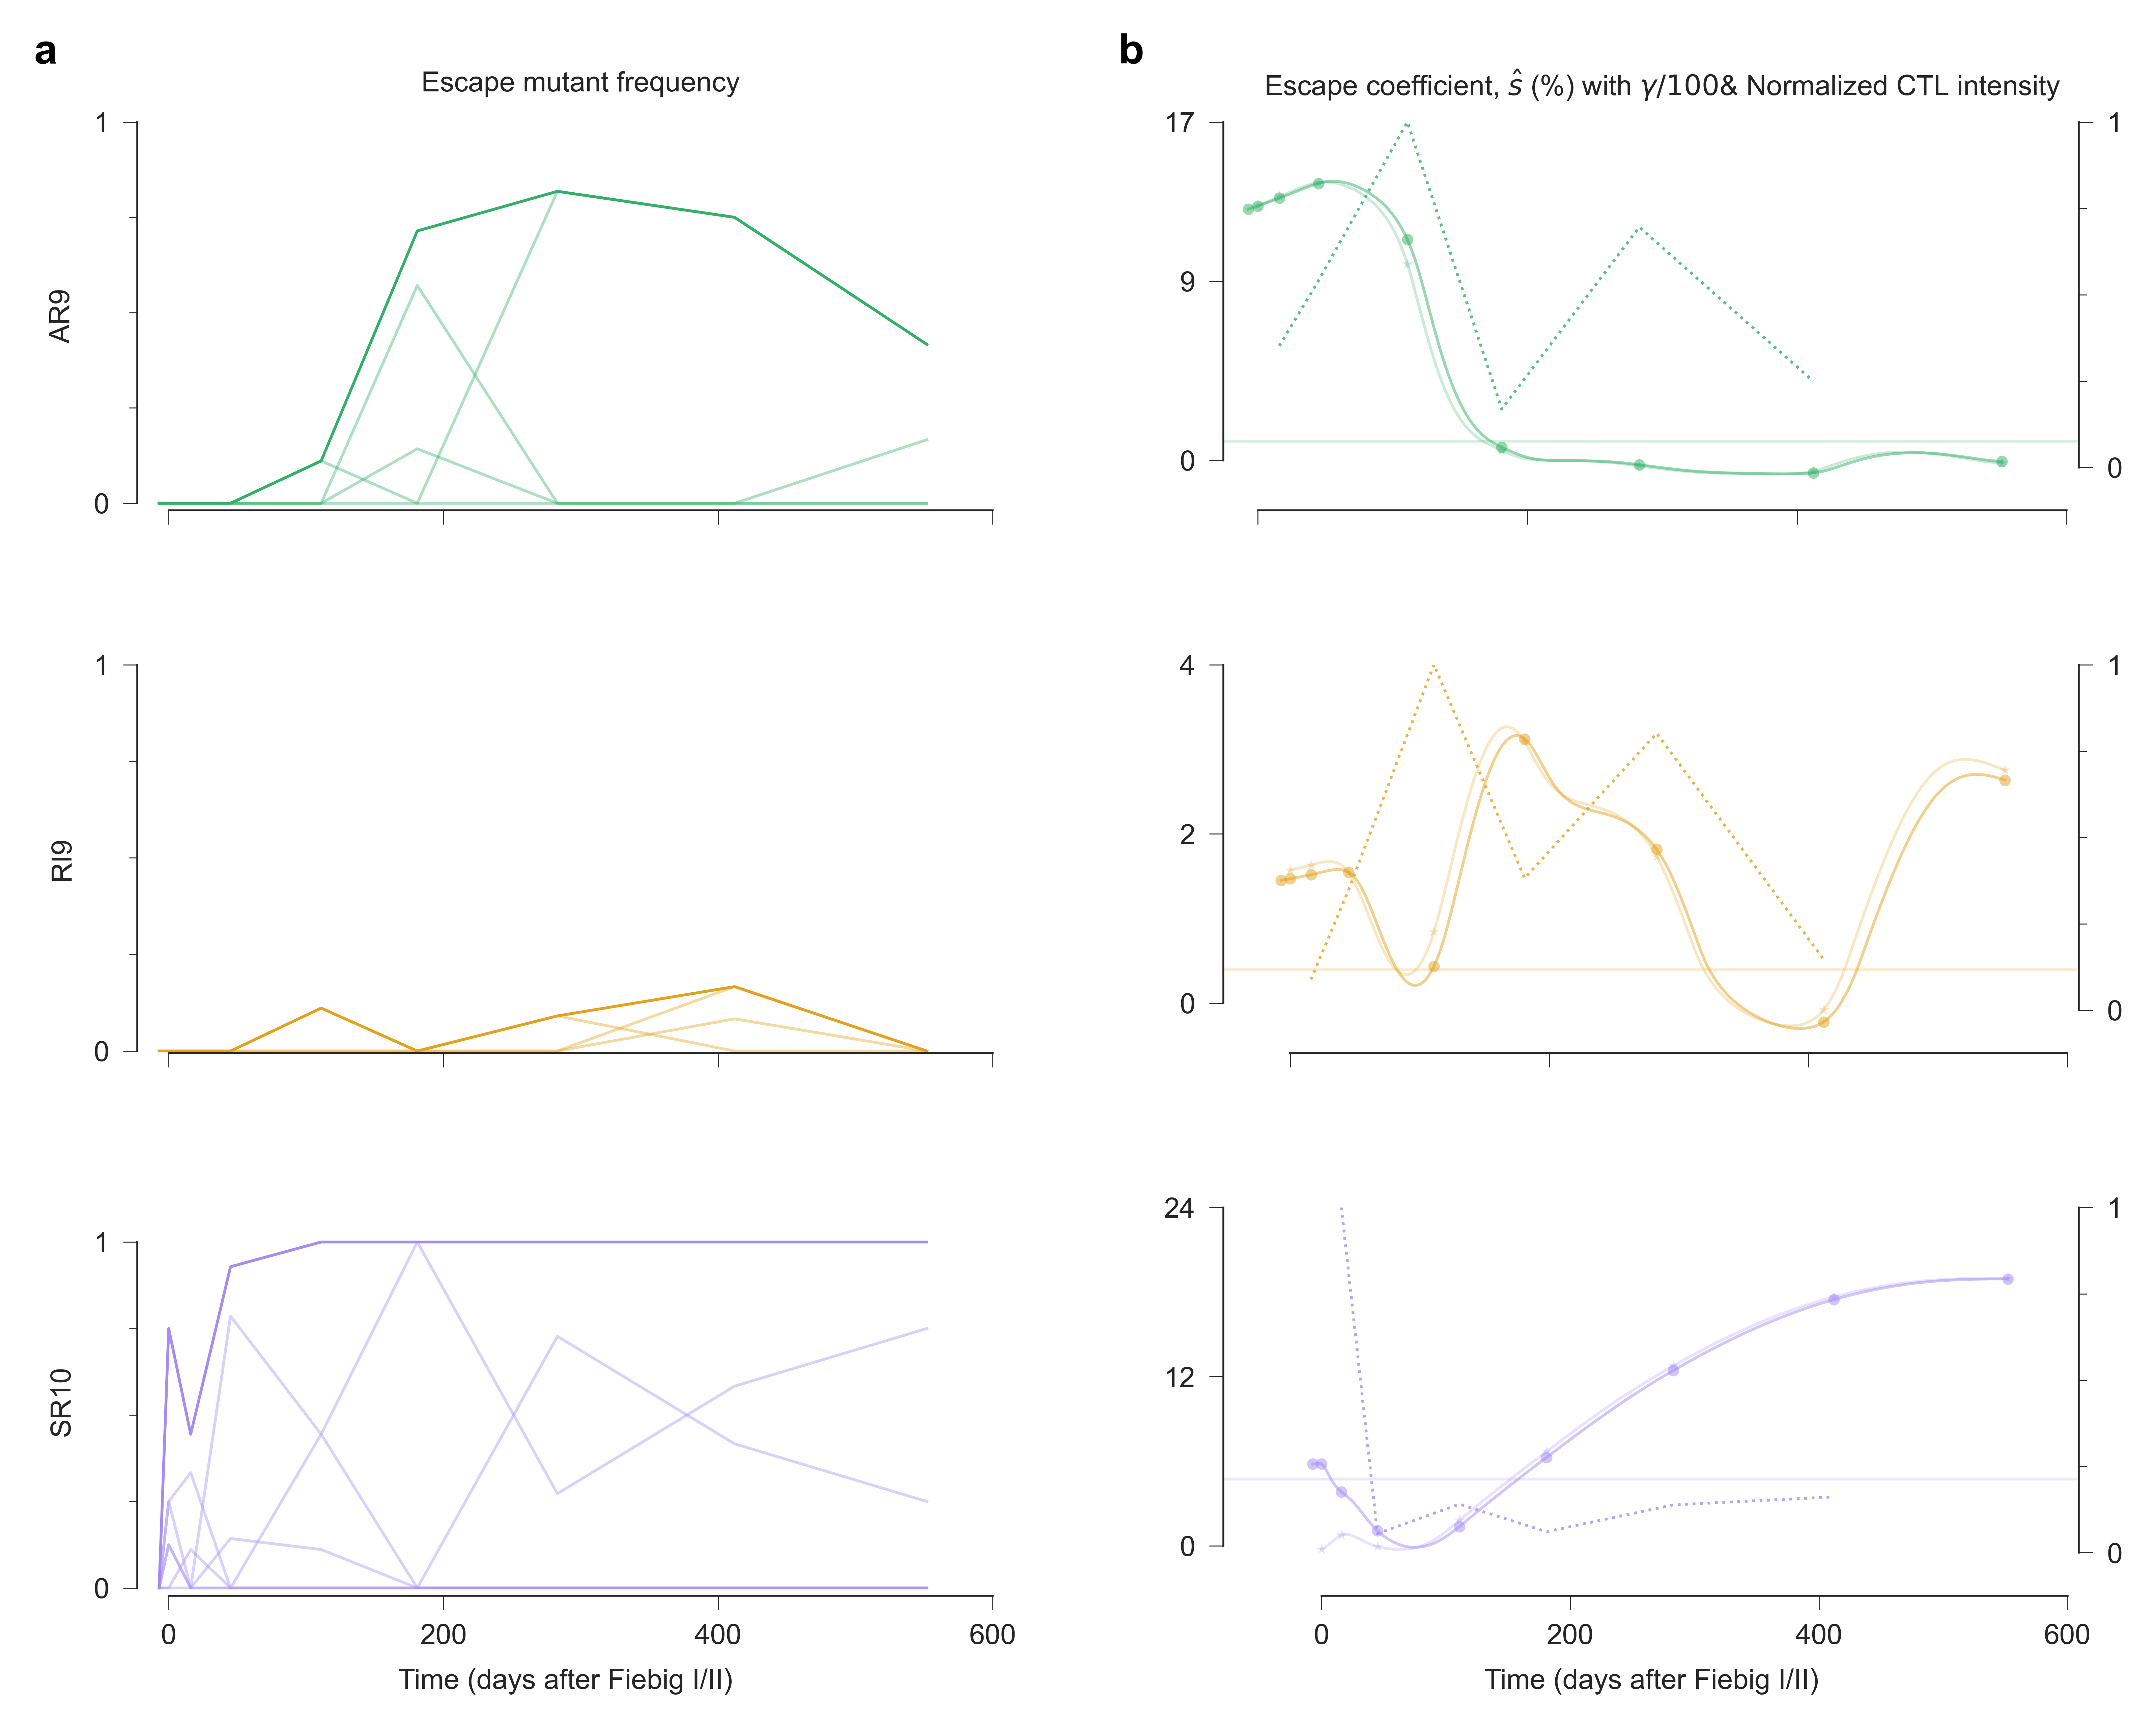

In [9]:
import figures as fig
importlib.reload(fig)

pdata = {                    
    'tag':       '700010040-3',
    'HIV_DIR':   'data/HIV',
    'FIG_DIR':   'figures',
    'output_dir':'output-fixation100',
    'name':      '-add',               # input file name
    'xtick':     [0 ,200, 400, 600],
    'xminortick':[],
    'ytick':     [[0, 0.09, 0.17], [0, 0.02, 0.04], [0, 0.12, 0.24]],
    'yminortick':[],
    'savepdf':   True,
        }

fig.plot_CH040(**pdata)

#### <a id='cut'></a> Cut sequence
Remove sites with weak linkage with trait sites, special sites and binary traits.

In [2]:
'Rename files'
HIV_DIR = 'data/HIV'

cut_tags = ['704010042-3', '703010131-3']

# for tag in cut_tags:
#     original_file1 = '%s/constant/analysis/%s-analyze.csv' %(HIV_DIR,tag) # original file path
#     new_file1      = '%s/constant/analysis/%s-analyze-old.csv' %(HIV_DIR,tag) 
#     os.rename(original_file1, new_file1)

#     original_file2 = '%s/constant/epitopes/escape_group-%s.csv' %(HIV_DIR,tag) # original file path
#     new_file2      = '%s/constant/epitopes/escape_group-%s-old.csv' %(HIV_DIR,tag) 
#     os.rename(original_file2, new_file2)

#     original_file = '%s/input/sequence/%s-poly-seq2state.dat' %(HIV_DIR,tag) # original file path
#     new_file      = '%s/input/sequence/%s-poly-seq2state-old.dat' %(HIV_DIR,tag) 
#     os.rename(original_file, new_file)


In [3]:
'''Create a new sequence file '/sequence/'+tag+'-cut.dat'''

import epitope
importlib.reload(epitope)

HIV_DIR = 'data/HIV'
tag = '704010042-3'
epitope.get_cut_sequences(HIV_DIR,tag,0.025,0.025)

tag = '703010131-3'
epitope.get_cut_sequences(HIV_DIR,tag,0.01,0.01)

CH042-3 raw sequence length is 875, remove 560 sites
CH131-3 raw sequence length is 744, remove 637 sites


In [4]:
'''Run C++ code to get constant results for short sequence'''

f = open("src/cut-HIV.sh",'w')
f.write('g++ main.cpp inf.cpp io.cpp -O3 -mcpu=apple-a14 -std=c++11 -lgsl -lgslcblas -o mpl\n')

cut_tags = ['704010042-3', '703010131-3']
for tag in cut_tags:

    original_file = '%s/constant/output/sc-%s.dat' %(HIV_DIR,tag) # original file path
    new_file      = '%s/constant/output/sc-%s-old.dat' %(HIV_DIR,tag) 
    os.rename(original_file, new_file)
    
    f.write('./mpl -d ../data/HIV -i input/sequence/%s-poly-seq2state.dat '%(tag))
    f.write('-o constant/output/sc-%s.dat -g 10 -m input/Zanini-extended.dat '%(tag))
    f.write('-r input/r_rates/r-%s.dat -e input/traitsite/traitsite-%s-cut.dat '%(tag,tag))
    f.write('-es input/traitseq/traitseq-%s.dat -ed input/traitdis/traitdis-%s.dat\n'%(tag,tag))
        
f.close()

In [6]:
'''Write the new inferred results to csv file 
(analysis/analyze-{tag}.csv and epitopes/escape_group-{tag}.csv)'''

import epitope
importlib.reload(epitope)

for tag in cut_tags:
    epitope.get_cut_analysis(HIV_DIR,tag)


#### <a id='add'></a> Add a time point
Add a TF sequence before start point for CH040 to make sure the escape frequency increase from a low value\
Files in this folder (paper-MPL-inference-master) can be downloaded from [the GitHub repo](https://github.com/bartonlab/paper-MPL-inference).

In [36]:
'''Sequence'''
Old_HIV_DIR = '../paper-MPL-inference-master/HIV/data'

add_tags = ['700010040-3','700010040-5']
for tag in tags:
    df_poly  = pd.read_csv('%s/constant/interim/%s-poly.csv' %(HIV_DIR,tag), comment='#', memory_map=True)
    poly_sites = df_poly['polymorphic_index'].unique()

    seq_str = ''
    for i in range(len(poly_sites)):
        df_poly_i = df_poly[df_poly['polymorphic_index'] == i]
        seq_str += str(NUC.index(df_poly_i.iloc[0]['TF']))
            
    with open('%s/input/sequence/%s-poly-seq2state-new.dat'%(HIV_DIR,tag), 'w') as fout:
        
        fout.write(f'-7\t1\t{" ".join(seq_str)}\n')
        
        with open('%s/input/sequence/%s-poly-seq2state.dat'%(HIV_DIR,tag), 'r') as fin:
            fout.write(fin.read())

In [56]:
'''Virus load '''
add_tags  = ['700010040-3','700010040-5']
for tag in tags:
    r_rates = np.loadtxt('%s/input/r_rates/r-%s.dat'%(HIV_DIR, tag))
    new_rates =  np.insert(r_rates, 0, r_rates[0])

    new_rates_str = [str(x) for x in new_rates]
    f = open('%s/input/r_rates/r-%s-new.dat'%(HIV_DIR,tag), 'w')
    f.write('%s\n'%'\t'.join(new_rates_str))
    f.close()

In [57]:
'''Collect data'''

tag_independent = []
tag_dependent   = []
tag_combine     = []
tag_noepitope   = []

for tag in tags:
    df   = pd.read_csv('%s/constant/analysis/%s-analyze.csv'%(HIV_DIR,tag), comment='#', memory_map=True)
    try:
        df_escape   = pd.read_csv('%s/constant/epitopes/escape_group-%s.csv'%(HIV_DIR,tag), memory_map=True)
        trait_sites = df_escape['polymorphic_index'].unique()
        traits      = df_escape['epitope'].unique()
        ne          = len(traits)
    except FileNotFoundError:
        trait_sites = []
        traits      = []
        ne          = 0

    seq_length   = df.iloc[-1]['polymorphic_index'] + 1
    variants     = len(df)
    sample_times = [int(i.split('_')[-1]) for i in df.columns if 'f_at_' in i]
    
    # Get special sites (nonsynonymous mutation for epitope but not trait sites)
    df_epis = df[(df['epitope'].notna()) & (df['escape'] == True)]
    epitopes = df_epis['epitope'].unique()
    nonsy_sites = df_epis['polymorphic_index'].unique()

    trait_index = []
    sp_index = []
    epitopes_name = [[],[]]
    for epitope in epitopes:
        df_epitope = df_epis[df_epis['epitope'] == epitope]
        epitope_sites = df_epitope['polymorphic_index'].unique()
        epitope_name = epitope[0] + epitope[-1] + str(len(epitope))
        if epitope in traits:
            trait_index.append(epitope_sites)
            epitopes_name[0].append(epitope_name)
        else:
            sp_index.append(epitope_sites)
            epitopes_name[1].append(epitope_name)
    
    # trait_output = "<br>".join([f"{epitopes_name[0][i]}: {trait_index[i]}" for i in range(len(trait_index))])
    # sp_out       = "<br>".join([f"{epitopes_name[1][i]}: {sp_index[i]}" for i in range(len(sp_index))])

    # print(f'CH{tag[-5:]}|{seq_length}|{variants}|{sample_times}|{ne}', end = '|')
    # print(f'{trait_output}|{sp_out}')

    name_tag = 'CH' + str(tag[-5:])
    if ne > 0 and len(sp_index) > 0:
        tag_combine.append(name_tag)
    elif ne > 0 and len(sp_index) == 0:
        tag_independent.append(name_tag)
    elif ne == 0 and len(sp_index) > 0:
        tag_dependent.append(name_tag)
    else:
        tag_noepitope.append(name_tag)
    
print(f'1. All epitopes are dependent {tag_dependent}')
print(f'2. All epitopes are independent {tag_independent}')
print(f'3. Combination of the above  {tag_combine}')
print(f'4. No mutation related to epitope {tag_noepitope}')


1. All epitopes are dependent []
2. All epitopes are independent []
3. Combination of the above  ['CH040-3', 'CH040-5']
4. No mutation related to epitope []


tag|sequence<br>length|variants|raw<br>time|escape<br>group|escape<br>sites|special<br>sites
:----:|:----:|:---:|:----|:----:|:----|:----
CH040-3|303|617|[0, 16, 45, 111, 181, 283, 412, 552]|3|AR9: [18 19 20 21]<br>RI9: [257 258 259]<br>SR10: [286 287 288 290 291]|EE9: [245 246]
CH040-5|146|292|[0, 16, 45, 111, 181, 283, 412, 552]|1|CR9: [31 32]|KL9: [39]<br>HT9: [104]
CH058-3|90|181|[0, 8, 45, 85]|1|EL9: [60 61 62 63]|
CH058-5|96|192|[0, 8, 45, 85, 154, 239, 252, 350]|1|TW10: [16 17]|IW9: [13]
CH077-3|203|424|[0, 14, 32, 102, 159]|6|DI9: [28 31 32 34 35]<br>TL9: [82 83 84 85]<br>QF10: [87 88 89]<br>DR9: [122 123 124 125]<br>DG9: [149 150 151 152 153 154 156 <br>157 158 159 160 161 162<br> 163 164 165 166 167 168 169 170 171]<br>KF9: [186 187 188 189 190]|
CH077-5|48|97|[0, 14, 32, 159]|0||IW9: [1]<br>TW10: [4 5]
CH470-3|367|772|[0, 13, 41, 69, 174, 420]|2|RK10: [0 1 2 3]<br>RK11: [352 353 355]|LP9: [40]<br>RI9: [302 303 304 305]<br>VK9: [334]
CH470-5|193|391|[0, 13, 41, 69, 174, 420, 454]|4|GK9: [8 9]<br>DL9: [23 24 25]<br>EK9: [78 79 81]<br>RL9: [149 150 151 152]|QK9: [124]
CH607-3|239|491|[0, 9, 14, 21]|1|KY11: [198 199 200 201 202]|
CH607-5|78|156|[0, 9, 14, 21]|0||
CH131-3|107|240|[0, 21, 28, 34, 63, 91, 175, 273, 333]|1|EV11: [90 91 92 93 94]|KC9: [17 18]<br>FY10: [19]<br>VV9: [34]<br>CI9: [50]<br>SI9: [73 74]
CH131-5|261|526|[0, 21, 28, 34, 63, 91, 175, 273, 333]|1|VF9: [14 15 16 19]|RY9: [259]
CH159-3|477|994|[0, 8, 12, 22, 29, 56, 85, 302]|2|PL9: [370 371 372 374 375 376]<br>RD9: [417 418 420 421 422 423 424]|
CH159-5|216|440|[0, 8, 12, 22, 29, 56, 85, 302]|0||
CH256-3|463|973|[0, 28, 63, 172, 426, 684]|3|EK9: [28 29 30 31 32 33]<br>RN9: [345 346 347 348 349]<br>LL9: [362 363 364 366]|EW10: [45 46]<br>TW9: [316 317]<br>QR9: [423 424 427]
CH256-5|402|812|[0, 28, 63, 172, 426, 684]|1|PS9: [169 170 171 172 174 175 176 177]|DA9: [42]<br>NA9: [208]
CH042-3|315|760|[0, 21, 60, 172, 424, 676]|3|DR9: [41 42]<br>KY9: [ 91  92  93  94  95  96  98  99 101]<br>RY9: [284 285]|NL9: [235 236 237 238 239 240]
CH042-5|266|538|[0, 21, 60, 172, 424, 676]|1|QP9: [29 30]|NQ9: [125]
CH162-3|508|1070|[0, 21, 77, 179, 438]|3|LI9: [33 34]<br>RA9: [290 291 292 293 294 295 <br>296 297 298 299 300 301 302 <br>303 304 305 306 307 308 309 310 <br>311 312 313 314 315 316 317]<br>EH9: [334 335 337]|KM9: [327 328]
CH162-5|254|513|[0, 21, 77, 179, 438]|0||VD9: [6 7 8]<br>GN9: [30 31 33]<br>EW9: [38 39 40 42 43]<br>VL9: [155]
CH185-3|292|595|[0, 25, 67, 180, 416]|0||
CH185-5|85|174|[0, 25, 67]|1|GY9: [2 3 4 5 6]|
CH198-3|204|427|[0, 11, 60]|1|KF9: [194 195 196]|
CH198-5|72|145|[0, 11, 60]|0||
CH164-3|485|1017|[0, 14, 28, 70, 183, 434]|1|EV11: [453 454 455 456 457 458]|NY9: [86 87 88 89]<br>SY9: [182 183 184 185 186 187 188]<br>KY11: [463]
CH164-5|204|409|[0, 14, 28, 70, 183, 434]|0||PF9: [44]<br>EA9: [50 51]<br>GW10: [170]


In [59]:
'''Time-varying gamma_prime with middle value is 50, boundary value is 200
   Fixation gamma is the normal gamma/10 '''

infer_tags = ['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3','700010077-5',
              '700010470-3','700010470-5','700010607-3','703010131-3','703010131-5','703010159-3',
              '703010256-3','703010256-5','704010042-3','704010042-5','705010162-3','705010162-5',
              '705010185-5','705010198-3','706010164-3','706010164-5']

f = open("%s/HIV.sh"%MPL_DIR,'w')
f.write('#!/bin/bash\n')
f.write('cd ..\n')

for tag in infer_tags:
    f.write('python inference_HIV.py -tag %s --raw'%(tag))
    f.write(' || echo "CH%s failed, continuing with next script..." \n'%tag[-5:])
f.write('echo "All scripts have been attempted."')
f.close()  

In [60]:
'''Add a time point'''

add_tags  = ['700010040-3','700010040-5']

f = open("%s/HIV-add.sh"%MPL_DIR,'w')
f.write('#!/bin/bash\n')
f.write('cd ..\n')

for tag in add_tags:
    f.write('python inference_HIV.py -tag %s --raw --add'%(tag))
    f.write(' || echo "CH%s failed, continuing with next script..." \n'%tag[-5:])
f.write('echo "All scripts have been attempted."')
f.close()  

### Use a shorter time gap

#### Find tag with the larger gap

In [12]:
HIV_DIR = 'data/HIV'
MAX_DT       = 200

infer_tags = ['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3',
              '700010077-5','700010470-3','700010470-5','700010607-3','703010131-3',
              '703010131-5','703010159-3','703010256-3','703010256-5','704010042-3',
              '704010042-5','705010162-3','705010162-5','705010185-5','705010198-3',
              '706010164-3','706010164-5']

change_tags = []
for tag in infer_tags:
    rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
    sample_times = rawdata['sample_times']
    dt_tag = [(sample_times[i+1]-sample_times[i]) for i in range(len(sample_times)-1)]
    if np.max(dt_tag) > MAX_DT:
        change_tags.append(tag)

print(change_tags)

['700010470-3', '700010470-5', '703010159-3', '703010256-3', '703010256-5', '704010042-3', '704010042-5', '705010162-3', '705010162-5', '706010164-3', '706010164-5']


#### Process sequences

In [14]:
import epitope
importlib.reload(epitope)

MAX_GAP_NUM  = 200
MAX_GAP_FREQ = 0.95
MIN_SEQS     = 4
MAX_DT       = 200
HIV_DIR_new = 'data/HIV'+str(MAX_DT)

epitope.process_sequence(MAX_GAP_NUM, MAX_GAP_FREQ, MIN_SEQS, MAX_DT, HIV_DIR_new, change_tags)

700010470-3
	selected 113 of 217 sequences with <200 gaps in excess of consensus
	removed 47 of 4681 sites with >95% gaps
700010470-5
	selected 104 of 217 sequences with <200 gaps in excess of consensus
	removed 2 of 4286 sites with >95% gaps
703010159-3
	selected 140 of 247 sequences with <200 gaps in excess of consensus
	removed 116 of 4744 sites with >95% gaps
	mutant at site 0 in codon that does not terminate in alignment, assuming syn
	mutant at site 0 in codon that does not terminate in alignment, assuming syn
	mutant at site 1 in codon that does not terminate in alignment, assuming syn
	mutant at site 1 in codon that does not terminate in alignment, assuming syn
703010256-3
	selected 99 of 209 sequences with <200 gaps in excess of consensus
	removed 59 of 4693 sites with >95% gaps
703010256-5
	selected 110 of 209 sequences with <200 gaps in excess of consensus
	removed 26 of 4301 sites with >95% gaps
	mutant at site 4274 in codon that does not terminate in alignment, assuming sy

#### find binary traits

In [71]:
import importlib
importlib.reload(epitope)

for tag in change_tags:
    epitope.find_nons_mutations(HIV_DIR_new,tag)

CH470-3 has 3 binary traits, epitope RK10 : [0, 1, 2, 3], epitope RI9 : [238, 239, 240, 241], epitope RK11 : [271, 272, 273], 
CH470-5 has 2 binary traits, epitope EK9 : [57, 59], epitope RL9 : [108, 109, 110, 111], 
CH159-3 has 2 binary traits, epitope PL9 : [223, 224, 225, 226, 227, 228], epitope RD9 : [254, 255, 257, 258, 259, 260, 261], 
CH256-3 has 4 binary traits, epitope EK9 : [10, 11, 12, 13, 14], epitope RN9 : [120, 121, 122, 123], epitope LL9 : [134, 135, 136, 137], epitope QR9 : [159, 160], 
CH256-5 has 1 binary traits, epitope PS9 : [77, 78, 79, 80, 81], 
CH042-3 has 3 binary traits, epitope DR9 : [20, 21], epitope KY9 : [51, 52], epitope NL9 : [396, 397, 398, 399, 400], 
CH042-5 has 1 binary traits, epitope QP9 : [9, 10], 
CH162-3 has 3 binary traits, epitope LI9 : [18, 19], epitope RA9 : [193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220], epitope EH9 : [226, 227, 229], 
CH162-5 has 3

In [84]:
import subprocess
importlib.reload(epitope)

status = subprocess.run('g++ src/rref.cpp -O3 -o rref.out', shell=True)

for tag in change_tags:
    co_rr = epitope.determine_dependence(HIV_DIR_new,tag)

status = subprocess.run('rm rref.out', shell=True)

CH162-5 : trait VD9, linked variants: 17A(GN9, WT), 17G(GN9), VD9, EW9, 
CH162-5 : trait EW9, linked variants: 17A(GN9, WT), 17G(GN9), VD9, EW9, 
CH164-3 : trait NY9, linked variants: 25G(NY9, WT), 25T(NY9), NY9, 
CH164-3 : trait SY9, linked variants: 51-(SY9), 51C(SY9, WT), 52-(SY9), 52C(SY9, WT), 53-(SY9), 53A(SY9, WT), 54-(SY9), 54A(SY9, WT), 55-(SY9), 55T(SY9, WT), 56-(SY9), 56T(SY9, WT), SY9, 


#### Show some basic information

In [92]:
# n_independent = 0
# n_dependent = 0
# TF_correct = True

# for tag in change_tags:

#     traitsite = epitope.read_file(HIV_DIR_new,'traitsite/traitsite-'+tag+'.dat')
#     TFseq     = epitope.read_file_s(HIV_DIR_new,'traitseq/traitseq-'+tag+'.dat')
    
#     df = pd.read_csv('%s/constant/interim/%s-poly.csv' %(HIV_DIR_new,tag), comment='#', memory_map=True)

#     variants     = len(df)
#     sample_times = [int(i.split('_')[-1]) for i in df.columns if 'f_at_' in i]
    
#     print(f'CH{tag[-5:]}|{sample_times[-1]}|{variants}', end = '|')
    
#     # Get special sites (nonsynonymous mutation for epitope but not trait sites)
#     df_epi = df[(df['epitope'].notna()) & (df['escape'] == True)]
#     epitopes = df_epi['epitope'].unique()
#     trait_index = []
#     sp_index = []
#     nonsy_sites = []
    
#     for n in range(len(epitopes)):
#         df_n = df_epi[(df_epi['epitope'] == epitopes[n]) ]
#         nonsy_sites_n = df_n['polymorphic_index'].unique()
#         nonsy_sites.append(nonsy_sites_n)
#         if any(np.array_equal(nonsy_sites_n, trait) for trait in traitsite):
#             trait_index.append(n)
#         else:
#             sp_index.append(n)
    
#     n_independent += len(trait_index)
#     n_dependent   += len(sp_index)
#     if len(traitsite)!= 0:
#         print(f'{len(traitsite)}', end = '|')
#         for nn in trait_index:
#             trait_epi = epitopes[nn]
#             epiname = trait_epi[0] + trait_epi[-1] + str(len(trait_epi))
#             print(f'<br>{epiname}: {nonsy_sites[nn]}', end = '')
#         print('',end = '|')
#     else:
#         print(f'0|No binary trait', end = '|')

#     if len(sp_index)!= 0:
#         for nn in sp_index:
#             sp_epi = epitopes[nn]
#             epiname = sp_epi[0] + sp_epi[-1] + str(len(sp_epi))
#             print(f'<br>{epiname}: {nonsy_sites[nn]}', end = '')
#     else:
#         print(f'No special sites', end = '')

#     print(f'|{sample_times}')

tag|max<br>time|variants|escape<br>group|escape sites|special sites|sample times
:----:|:----:|:----:|:----:|:---|:----|:-----
CH470-3|174|583|3|RK10: [0 1 2 3]<br>RI9: [238 239 240 241]<br>RK11: [271 272 273]|LP9: [32]|[0, 13, 41, 69, 174]
CH470-5|174|280|2|EK9: [57 59]<br>RL9: [108 109 110 111]|GK9: [8]<br>DL9: [17]<br>QK9: [90]|[0, 13, 41, 69, 174]
CH159-3|85|634|2|PL9: [223 224 225 226 227 228]<br>RD9: [254 255 257 258 259 260 261]|No special sites|[0, 8, 12, 22, 29, 56, 85]
CH256-3|172|355|4|EK9: [10 11 12 13 14]<br>RN9: [120 121 122 123]<br>LL9: [134 135 136 137]<br>QR9: [159 160]|EW10: [20]<br>TW9: [105]|[0, 28, 63, 172]
CH256-5|172|474|1|PS9: [77 78 79 80 81]|No special sites|[0, 28, 63, 172]
CH042-3|172|1084|3|DR9: [20 21]<br>KY9: [51 52]<br>NL9: [396 397 398 399 400]|RY9: [426]|[0, 21, 60, 172]
CH042-5|172|160|1|QP9: [ 9 10]|No special sites|[0, 21, 60, 172]
CH162-3|179|798|3|LI9: [18 19]<br>RA9: [193 194 195 196 197 198 199<br> 200 201 202 203 204 205 206<br> 207 208 209 210 211 212 <br>213 214 215 216 217 218 219 220]<br>EH9: [226 227 229]|KM9: [224]|[0, 21, 77, 179]
CH162-5|179|270|1|GN9: [15 16 17]|VD9: [2 3]<br>EW9: [19 20 21 22]|[0, 21, 77, 179]
CH164-3|183|555|1|EV11: [264 265 266 267 268]|NY9: [23 24 25]<br>SY9: [51 52 53 54 55 56]<br>KY11: [269]|[0, 14, 28, 70, 183]
CH164-5|183|219|0|No binary trait|PF9: [27]<br>GW10: [93]|[0, 14, 28, 70, 183]


In [19]:

def get_times(tag):
    seq      = np.loadtxt('%s/input/sequence/%s-poly-seq2state.dat'%(HIV_DIR_new,tag))
    times = []
    for i in range(len(seq)):
        times.append(seq[i][0])
    return np.unique(times)


for tag in change_tags:

    ppt = tag[:9]
    
    df_vl_raw    = pd.read_csv('%s/raw/virus load/%s.csv' %(HIV_DIR_new,ppt), header=None)
    df_vl_raw.columns = ['time', 'virus_load']
    df_vl = df_vl_raw.sort_values(by='time', ascending=True)

    sample_times = get_times(tag)
    
    times = [int(i) for i in df_vl['time'].values]
    virus_load = [np.power(10, i) for i in df_vl['virus_load'].values]
    vl_sample = np.zeros(len(sample_times))
    
#     if sample_times[-1] > times[-1]:
#         print(f'CH{tag[-5:]} last time point is {int(sample_times[-1])}, the last point detected VL is {times[-1]}')
    #     print(f'there are some time points have no VL')

    time_min = np.min([int(times[0]),sample_times[0]])
    time_max = np.max([int(times[-1]),sample_times[-1]])
    whole_time = np.linspace(time_min,time_max,int(time_max-time_min+1))
    
    interpolation = lambda a,b: sp_interpolate.interp1d(a,b,kind='linear',fill_value=(virus_load[0], virus_load[-1]), bounds_error=False)
    AllVL = interpolation(times, virus_load)(whole_time)

    for t_index in range(len(sample_times)):
        t = sample_times[t_index]
        index = list(whole_time).index(t)
        vl_sample[t_index] = AllVL[index]
        
    # recombination rate over time
    f = open('%s/input/r_rates/r-%s.dat'%(HIV_DIR_new,tag), 'w')
    f.write('%s\n'%'\t'.join([str((1.722*vl_sample[i]/1000000+0.139)/10000) for i in range(len(vl_sample))]))
    f.close()
    

#### run constant MPL

In [20]:
f = open("src/const-HIV-%d.sh"%MAX_DT,'w')
f.write('g++ main.cpp inf.cpp io.cpp -O3 -mcpu=apple-a14 -std=c++11 -lgsl -lgslcblas -o mpl\n')

for tag in change_tags:
            
    f.write('./mpl -d ../data/HIV%d -i input/sequence/%s-poly-seq2state.dat '%(MAX_DT,tag))
    f.write('-o constant/output/sc-%s.dat -g 10 -m input/Zanini-extended.dat '%(tag))
    f.write('-r input/r_rates/r-%s.dat -e input/traitsite/traitsite-%s.dat '%(tag,tag))
    f.write('-es input/traitseq/traitseq-%s.dat -ed input/traitdis/traitdis-%s.dat '%(tag,tag))
    f.write('-sc constant/output/c-%s.dat\n'%(tag))
        
f.close()

Check if every binary trait is indepedent

In [25]:
importlib.reload(epitope)

status = subprocess.run('g++ src/rref.cpp -O3 -o rref.out', shell=True)
epitope.get_independent(HIV_DIR_new)
status = subprocess.run('rm rref.out', shell=True)

Done!


In [26]:
importlib.reload(epitope)

Independence = True

for tag in change_tags:
    
    co_rr     = np.loadtxt('%s/constant/output/rr-c-%s.dat'%(HIV_DIR_new,tag))
    
    traitsite = epitope.read_file(HIV_DIR_new,'traitsite/traitsite-'+tag+'.dat')
    
    ll = len(co_rr)
    ne = len(traitsite)
    
    if ne > 0:
        
        for n in range(ne):
            co_rr_c = list(co_rr.T[ll-ne+n])
            
            pivot = co_rr_c.index(np.sum(co_rr_c))
                
            if np.sum(abs(co_rr[pivot])) > 1:
                Independence = False
                print(f'{tag} still has some dependent binary trait, {traitsite[n]}')

cov_dir = HIV_DIR_new + '/constant/output'

if Independence == True:
    status = subprocess.run('rm %s/rr-c-*.dat'%cov_dir, shell=True)
    status = subprocess.run('rm %s/c-*.dat'%cov_dir, shell=True)
    print('All inferred binary traits are independent')

All inferred binary traits are independent


Deal with the constant data

In [17]:
importlib.reload(epitope)

for tag in change_tags:
    epitope.analyze_result(HIV_DIR_new,tag)

print('Successfully create the analysis and escape group file')

Successfully create the analysis and escape group file


In [12]:
'''Time-varying gamma_prime with middle value is 50'''

HIV_DIR_new = 'data/HIV'+str(MAX_DT)
f = open("src/HIV-%d.sh"%MAX_DT,'w')

f.write('#!/bin/bash\n')
f.write('cd ..\n')

for tag in change_tags:
    f.write('python new_infer.py -tag %s -dir %s --raw'%(tag,HIV_DIR_new))
    f.write(' || echo "CH%s failed, continuing with next script..." \n'%tag[-5:])
f.write('echo "All scripts have been attempted."')
f.close()



In [15]:
'''Time-varying gamma_prime with middle value is 50'''

HIV_DIR_new = 'data/HIV'+str(MAX_DT)
f = open("src/try-HIV-%d.sh"%MAX_DT,'w')

tag = '703010256-3'
g2s = [100,150,200]
f.write('#!/bin/bash\n')
f.write('cd ..\n')

for g2 in g2s:
    f.write('python new_infer.py -tag %s -name %s -dir %s -g2tv %s'%(tag,g2,HIV_DIR_new,g2))
    f.write(' || echo "CH%s failed, continuing with next script..." \n'%tag[-5:])
f.write('echo "All scripts have been attempted."')
f.close()

### Shorter time - 250

In [7]:
HIV_DIR = 'data/HIV'
MAX_DT       = 250

infer_tags = ['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3',
              '700010077-5','700010470-3','700010470-5','700010607-3','703010131-3',
              '703010131-5','703010159-3','703010256-3','703010256-5','704010042-3',
              '704010042-5','705010162-3','705010162-5','705010185-5','705010198-3',
              '706010164-3','706010164-5']

change_tags = []
for tag in infer_tags:
    rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
    sample_times = rawdata['sample_times']
    dt_tag = [(sample_times[i+1]-sample_times[i]) for i in range(len(sample_times)-1)]
    if np.max(dt_tag) > MAX_DT:
        change_tags.append(tag)

print(change_tags)

['703010256-3', '703010256-5', '704010042-3', '704010042-5', '705010162-3', '705010162-5', '706010164-3', '706010164-5']


In [11]:
import importlib
importlib.reload(epitope)

MAX_GAP_NUM  = 200
MAX_GAP_FREQ = 0.95
MIN_SEQS     = 4
MAX_DT       = 250

HIV_DIR_new = 'data/HIV'+str(MAX_DT)

epitope.process_sequence(MAX_GAP_NUM, MAX_GAP_FREQ, MIN_SEQS, MAX_DT, HIV_DIR_new, change_tags)

703010256-3
	selected 99 of 209 sequences with <200 gaps in excess of consensus
	removed 59 of 4693 sites with >95% gaps
703010256-5
	selected 110 of 209 sequences with <200 gaps in excess of consensus
	removed 26 of 4301 sites with >95% gaps
	mutant at site 4274 in codon that does not terminate in alignment, assuming syn
	mutant at site 4274 in codon that does not terminate in alignment, assuming syn
704010042-3
	selected 93 of 179 sequences with <200 gaps in excess of consensus
	removed 62 of 4714 sites with >95% gaps
704010042-5
	selected 85 of 179 sequences with <200 gaps in excess of consensus
	removed 26 of 4280 sites with >95% gaps
	mutant at site 4253 in codon that does not terminate in alignment, assuming syn
	mutant at site 4253 in codon that does not terminate in alignment, assuming syn
705010162-3
	selected 69 of 149 sequences with <200 gaps in excess of consensus
	removed 70 of 4735 sites with >95% gaps
705010162-5
	selected 60 of 149 sequences with <200 gaps in excess of 

In [12]:
import importlib
importlib.reload(epitope)

for tag in change_tags:
    epitope.find_nons_mutations(HIV_DIR_new,tag)

CH256-3 has 4 binary traits, epitope EK9 : [10, 11, 12, 13, 14], epitope RN9 : [120, 121, 122, 123], epitope LL9 : [134, 135, 136, 137], epitope QR9 : [159, 160], 
CH256-5 has 1 binary traits, epitope PS9 : [77, 78, 79, 80, 81], 
CH042-3 has 3 binary traits, epitope DR9 : [20, 21], epitope KY9 : [51, 52], epitope NL9 : [396, 397, 398, 399, 400], 
CH042-5 has 1 binary traits, epitope QP9 : [9, 10], 
CH162-3 has 3 binary traits, epitope LI9 : [18, 19], epitope RA9 : [193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220], epitope EH9 : [226, 227, 229], 
CH162-5 has 3 binary traits, epitope VD9 : [2, 3], epitope GN9 : [15, 16, 17], epitope EW9 : [19, 20, 21, 22], 
CH164-3 has 3 binary traits, epitope NY9 : [23, 24, 25], epitope SY9 : [51, 52, 53, 54, 55, 56], epitope EV11 : [264, 265, 266, 267, 268], 
706010164-5 has no bianry trait


In [13]:
import subprocess
importlib.reload(epitope)

status = subprocess.run('g++ src/rref.cpp -O3 -o rref.out', shell=True)

for tag in change_tags:
    co_rr = epitope.determine_dependence(HIV_DIR_new,tag)

status = subprocess.run('rm rref.out', shell=True)

CH162-5 : trait VD9, linked variants: 17A(GN9, WT), 17G(GN9), VD9, EW9, 
CH162-5 : trait EW9, linked variants: 17A(GN9, WT), 17G(GN9), VD9, EW9, 
CH164-3 : trait NY9, linked variants: 25G(NY9, WT), 25T(NY9), NY9, 
CH164-3 : trait SY9, linked variants: 51-(SY9), 51C(SY9, WT), 52-(SY9), 52C(SY9, WT), 53-(SY9), 53A(SY9, WT), 54-(SY9), 54A(SY9, WT), 55-(SY9), 55T(SY9, WT), 56-(SY9), 56T(SY9, WT), SY9, 


In [15]:
# n_independent = 0
# n_dependent = 0
# TF_correct = True

# for tag in change_tags:

#     traitsite = epitope.read_file(HIV_DIR_new,'traitsite/traitsite-'+tag+'.dat')
#     TFseq     = epitope.read_file_s(HIV_DIR_new,'traitseq/traitseq-'+tag+'.dat')
    
#     df = pd.read_csv('%s/constant/interim/%s-poly.csv' %(HIV_DIR_new,tag), comment='#', memory_map=True)

#     variants     = len(df)
#     sample_times = [int(i.split('_')[-1]) for i in df.columns if 'f_at_' in i]
    
#     print(f'CH{tag[-5:]}|{sample_times[-1]}|{variants}', end = '|')
    
#     # Get special sites (nonsynonymous mutation for epitope but not trait sites)
#     df_epi = df[(df['epitope'].notna()) & (df['escape'] == True)]
#     epitopes = df_epi['epitope'].unique()
#     trait_index = []
#     sp_index = []
#     nonsy_sites = []
    
#     for n in range(len(epitopes)):
#         df_n = df_epi[(df_epi['epitope'] == epitopes[n]) ]
#         nonsy_sites_n = df_n['polymorphic_index'].unique()
#         nonsy_sites.append(nonsy_sites_n)
#         if any(np.array_equal(nonsy_sites_n, trait) for trait in traitsite):
#             trait_index.append(n)
#         else:
#             sp_index.append(n)
    
#     n_independent += len(trait_index)
#     n_dependent   += len(sp_index)
#     if len(traitsite)!= 0:
#         print(f'{len(traitsite)}', end = '|')
#         for nn in trait_index:
#             trait_epi = epitopes[nn]
#             epiname = trait_epi[0] + trait_epi[-1] + str(len(trait_epi))
#             print(f'<br>{epiname}: {nonsy_sites[nn]}', end = '')
#         print('',end = '|')
#     else:
#         print(f'0|No binary trait', end = '|')

#     if len(sp_index)!= 0:
#         for nn in sp_index:
#             sp_epi = epitopes[nn]
#             epiname = sp_epi[0] + sp_epi[-1] + str(len(sp_epi))
#             print(f'<br>{epiname}: {nonsy_sites[nn]}', end = '')
#     else:
#         print(f'No special sites', end = '')

#     print(f'|{sample_times}')

tag|max<br>time|variants|escape<br>group|escape sites|special sites|sample times
:----:|:----:|:----:|:----:|:---|:----|:-----
CH256-3|172|355|4|EK9: [10 11 12 13 14]<br>RN9: [120 121 122 123]<br>LL9: [134 135 136 137]<br>QR9: [159 160]|EW10: [20]<br>TW9: [105]|[0, 28, 63, 172]
CH256-5|172|474|1|PS9: [77 78 79 80 81]|No special sites|[0, 28, 63, 172]
CH042-3|172|1084|3|DR9: [20 21]<br>KY9: [51 52]<br>NL9: [396 397 398 399 400]|RY9: [426]|[0, 21, 60, 172]
CH042-5|172|160|1|QP9: [ 9 10]|No special sites|[0, 21, 60, 172]
CH162-3|179|798|3|LI9: [18 19]<br>RA9: [193 194 195 196 197 198 199<br>200 201 202 203 204 205 206<br>207 208 209 210 211 212 213<br>214 215 216 217 218 219 220]<br>EH9: [226 227 229]|KM9: [224]|[0, 21, 77, 179]
CH162-5|179|270|1|GN9: [15 16 17]|VD9: [2 3]<br>EW9: [19 20 21 22]|[0, 21, 77, 179]
CH164-3|183|555|1|EV11: [264 265 266 267 268]|NY9: [23 24 25]<br>SY9: [51 52 53 54 55 56]<br>KY11: [269]|[0, 14, 28, 70, 183]
CH164-5|183|219|0|No binary trait|PF9: [27]<br>GW10: [93]|[0, 14, 28, 70, 183]


In [22]:

def get_times(tag):
    seq      = np.loadtxt('%s/input/sequence/%s-poly-seq2state.dat'%(HIV_DIR_new,tag))
    times = []
    for i in range(len(seq)):
        times.append(seq[i][0])
    return np.unique(times)


for tag in change_tags:

    ppt = tag[:9]
    
    df_vl_raw    = pd.read_csv('%s/raw/virus load/%s.csv' %(HIV_DIR_new,ppt), header=None)
    df_vl_raw.columns = ['time', 'virus_load']
    df_vl = df_vl_raw.sort_values(by='time', ascending=True)

    sample_times = get_times(tag)
    
    times = [int(i) for i in df_vl['time'].values]
    virus_load = [np.power(10, i) for i in df_vl['virus_load'].values]
    vl_sample = np.zeros(len(sample_times))
    
#     if sample_times[-1] > times[-1]:
#         print(f'CH{tag[-5:]} last time point is {int(sample_times[-1])}, the last point detected VL is {times[-1]}')
    #     print(f'there are some time points have no VL')

    time_min = np.min([int(times[0]),sample_times[0]])
    time_max = np.max([int(times[-1]),sample_times[-1]])
    whole_time = np.linspace(time_min,time_max,int(time_max-time_min+1))
    
    interpolation = lambda a,b: sp_interpolate.interp1d(a,b,kind='linear',fill_value=(virus_load[0], virus_load[-1]), bounds_error=False)
    AllVL = interpolation(times, virus_load)(whole_time)

    for t_index in range(len(sample_times)):
        t = sample_times[t_index]
        index = list(whole_time).index(t)
        vl_sample[t_index] = AllVL[index]
        
    # recombination rate over time
    f = open('%s/input/r_rates/r-%s.dat'%(HIV_DIR_new,tag), 'w')
    f.write('%s\n'%'\t'.join([str((1.722*vl_sample[i]/1000000+0.139)/10000) for i in range(len(vl_sample))]))
    f.close()
    

In [70]:
f = open("src/const-HIV-%d.sh"%MAX_DT,'w')
f.write('g++ main.cpp inf.cpp io.cpp -O3 -mcpu=apple-a14 -std=c++11 -lgsl -lgslcblas -o mpl\n')

for tag in change_tags:
            
    f.write('./mpl -d ../data/HIV%d -i input/sequence/%s-poly-seq2state.dat '%(MAX_DT,tag))
    f.write('-o constant/output/sc-%s.dat -g 10 -m input/Zanini-extended.dat '%(tag))
    f.write('-r input/r_rates/r-%s.dat -e input/traitsite/traitsite-%s.dat '%(tag,tag))
    f.write('-es input/traitseq/traitseq-%s.dat -ed input/traitdis/traitdis-%s.dat '%(tag,tag))
    f.write('-sc constant/output/c-%s.dat\n'%(tag))
        
f.close()

In [31]:
importlib.reload(epitope)

status = subprocess.run('g++ src/rref.cpp -O3 -o rref.out', shell=True)
epitope.get_independent(HIV_DIR_new)
status = subprocess.run('rm rref.out', shell=True)

Done!


In [32]:
importlib.reload(epitope)

Independence = True

for tag in change_tags:
    
    co_rr     = np.loadtxt('%s/constant/output/rr-c-%s.dat'%(HIV_DIR_new,tag))
    
    traitsite = epitope.read_file(HIV_DIR_new,'traitsite/traitsite-'+tag+'.dat')
    
    ll = len(co_rr)
    ne = len(traitsite)
    
    if ne > 0:
        
        for n in range(ne):
            co_rr_c = list(co_rr.T[ll-ne+n])
            
            pivot = co_rr_c.index(np.sum(co_rr_c))
                
            if np.sum(abs(co_rr[pivot])) > 1:
                Independence = False
                print(f'{tag} still has some dependent binary trait, {traitsite[n]}')

cov_dir = HIV_DIR_new + '/constant/output'

if Independence == True:
    status = subprocess.run('rm %s/rr-c-*.dat'%cov_dir, shell=True)
    status = subprocess.run('rm %s/c-*.dat'%cov_dir, shell=True)
    print('All inferred binary traits are independent')

All inferred binary traits are independent


In [33]:
importlib.reload(epitope)

for tag in change_tags:
    epitope.analyze_result(HIV_DIR_new,tag)

print('Successfully create the analysis and escape group file')

Successfully create the analysis and escape group file


In [34]:
'''Time-varying gamma_prime with middle value is 50'''


f = open("src/HIV-%d.sh"%MAX_DT,'w')

f.write('#!/bin/bash\n')
f.write('cd ..\n')

for tag in change_tags:
    f.write('python new_infer.py -tag %s -dir %s --raw'%(tag,HIV_DIR_new))
    f.write(' || echo "CH%s failed, continuing with next script..." \n'%tag[-5:])
f.write('echo "All scripts have been attempted."')
f.close()



In [ ]:
importlib.reload(fig)

pdata = {
    'tag':       '700010040-3',
    'HIV_DIR1':   'data/HIV',
    'HIV_DIR2':   'data/HIV200',
    'FIG_DIR':   'figures/HIV200',
    'name':      '',               # input file name
    'xtick':     [],
    'xminortick':[],
    'ytick':     [],
    'yminortick':[],
    'ytick_sp':  [],
    'yminor_sp': [],
    'savepdf':   False,
        }

tags_200 = ['700010470-3','700010470-5','703010159-3','703010256-3','703010256-5','704010042-3',
            '704010042-5','705010162-3','705010162-5','706010164-3','706010164-5']
for tag in tags_200:
    pdata['tag'] = tag
    fig.plot_epitopes_dt(**pdata)
    plt.close()
